In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
from sklearn.model_selection import train_test_split
import gensim
import os
import collections
import smart_open
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine, euclidean
import re
import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression

from segment_data import save_in_pkl
from pair_data import read_in_pkl

In [2]:
class Doc2VecModeler(object):
    '''
    Uses Gensim's Doc2Vec model to keep track of different model variations for comparison
    '''
    def __init__(self, model_name, train_corpus, training_corpus_name,
                 vector_size=100, dm=1, min_count=2, epochs=100):
        self.model_name = model_name
        self.train_corpus = train_corpus
        self.n_training_docs = len(self.train_corpus)
        self.training_corpus_name = training_corpus_name
        self.vector_size = vector_size
        self.dm = dm
        self.min_count = min_count
        self.epochs = epochs

        self.inferred_vecs = {'docs': [], 'vecs': []}

    def fit_model(self, verbose=False):
        model = gensim.models.doc2vec.Doc2Vec(vector_size=self.vector_size,
                                              dm=self.dm,
                                              min_count=self.min_count,
                                              epochs=self.epochs)
        model.build_vocab(self.train_corpus)
        model.train(self.train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
        if verbose:
            print("Model training complete!")
        self.model = model
        # return model

    def calc_self_recognition_ability(self):
        # ability to recognize a training doc as its own best match
        model = self.model
        ranks = []
        second_ranks = []
        for doc_id in range(self.n_training_docs):
            doc = self.train_corpus[doc_id].words
            inferred_vector = self.model.infer_vector(doc, epochs=self.epochs)

            self.inferred_vecs['docs'].append(doc)
            self.inferred_vecs['vecs'].append(inferred_vector)

            sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
            #gives you all document tags and their cosine similarity
            # Gets its own self-ranking
            rank = [docid for docid, sim in sims].index(doc_id)
            ranks.append(rank)
            second_ranks.append(sims[1])
        # Let's count how each document ranks with respect to the training corpus
        rank_counter = collections.Counter(ranks)
        # Results vary between runs due to random seeding and very small corpus
        self.rank_counter = rank_counter
        self.n_self_recognized = self.rank_counter[0]
        self.self_recog_rate = self.n_self_recognized / self.n_training_docs
        self.greater_than_95 = self.self_recog_rate >= 0.95
        return self.greater_than_95

    def calculate_pair_sims_array(self, pairings_df, is_train=True):
#         is_train = pairings_df == train_pairings_df
        ref_vecs = []
        tate_vecs = []
        rt_cs = []
        rt_ed = []
        for row in pairings_df.index:
            ref_doc = pairings_df.loc[row,['ref_pp_text']][0]
            tate_doc = pairings_df.loc[row,['tate_pp_text']][0]

            inf_ref_vec = self.model.infer_vector(ref_doc, epochs=self.epochs).reshape(-1, 1)
            inf_tate_vec = self.model.infer_vector(tate_doc, epochs=self.epochs).reshape(-1, 1)

            ref_vecs.append(inf_ref_vec)
            tate_vecs.append(inf_tate_vec)

            cs = 1 - cosine(inf_ref_vec, inf_tate_vec)
            ed = euclidean(inf_ref_vec, inf_tate_vec)

            rt_cs.append(cs)
            rt_ed.append(ed)


        calc_pairings_df = pairings_df.copy()
        calc_pairings_df['ref_vecs'] = ref_vecs
        calc_pairings_df['tate_vecs'] = tate_vecs
        calc_pairings_df['pair_cs'] = rt_cs
        calc_pairings_df['pair_ed'] = rt_ed

        is_true_pair = calc_pairings_df['is_pair'] == 1

        avg_true_pair_cs = calc_pairings_df[is_true_pair]['pair_cs'].mean()
        avg_false_pair_cs = calc_pairings_df[~is_true_pair]['pair_cs'].mean()
        max_true_pair_cs = calc_pairings_df[is_true_pair]['pair_cs'].max()
        max_false_pair_cs = calc_pairings_df[~is_true_pair]['pair_cs'].max()
        min_true_pair_cs = calc_pairings_df[is_true_pair]['pair_cs'].min()
        min_false_pair_cs = calc_pairings_df[~is_true_pair]['pair_cs'].min()

        pair_cs_stats = {'avg_tru':avg_true_pair_cs, 'avg_false':avg_false_pair_cs, 'max_tru':max_true_pair_cs, 'max_false':max_false_pair_cs, 'min_tru':min_true_pair_cs, 'min_false':min_false_pair_cs}

        if is_train:
            self.tr_pairings_df = calc_pairings_df.copy()
            self.train_true_cs = calc_pairings_df[calc_pairings_df['is_pair'] == 1]['pair_cs']
            self.train_false_cs = calc_pairings_df[calc_pairings_df['is_pair'] == 0]['pair_cs']
            self.train_true_ed = calc_pairings_df[calc_pairings_df['is_pair'] == 1]['pair_ed']
            self.train_false_ed = calc_pairings_df[calc_pairings_df['is_pair'] == 0]['pair_ed']
            self.tr_pairings_stats = pair_cs_stats
        else:
            self.tst_pairings_df = calc_pairings_df.copy()
            self.test_true_cs = calc_pairings_df[calc_pairings_df['is_pair'] == 1]['pair_cs']
            self.test_false_cs = calc_pairings_df[calc_pairings_df['is_pair'] == 0]['pair_cs']
            self.test_true_ed = calc_pairings_df[calc_pairings_df['is_pair'] == 1]['pair_ed']
            self.test_false_ed = calc_pairings_df[calc_pairings_df['is_pair'] == 0]['pair_ed']
            self.tst_pairings_stats = pair_cs_stats

    def calc_tt_hypothesis_test(self, for_train_pairings=True, for_cs=True):
        pairs_df = self.tr_pairings_df if for_train_pairings else self.tst_pairings_df
        sim_col = 'pair_cs' if for_cs else 'pair_ed'
        true_sims = pairs_df[pairs_df['is_pair'] == 1][sim_col]
        false_sims = pairs_df[pairs_df['is_pair'] == 0][sim_col]
        stat, p = ttest_ind(true_sims, false_sims)
        if for_train_pairings:
            self.train_stat = stat
            self.train_p_val = p
            self.is_train_significant = p < 0.01
        else:
            self.test_stat = stat
            self.test_p_val = p
            self.is_test_significant = p < 0.01

    def plot_sim_distribution(self, use_train=True, use_cs=True, save_fig=False):
        if use_train:
            tru_pairs = self.train_true_cs if use_cs else self.train_true_ed
            non_pairs = self.train_false_cs if use_cs else self.train_false_ed
        else:
            tru_pairs = self.test_true_cs if use_cs else self.test_true_ed
            non_pairs = self.test_false_cs if use_cs else self.test_false_ed

        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot(111)

        title = "Distributions of DocVec Similarity - Model:" + self.model_name

        ax.set_title(title, fontsize=18)

        plt.hist(non_pairs, bins=100, color='red', alpha=0.3, label='mismatched pairs')
        plt.hist(tru_pairs, bins=100, color='blue', alpha=0.3, label='true pairs')

        plt.axvline(x=tru_pairs.mean(), c='blue', alpha=0.6, linewidth=3)
        plt.axvline(x=non_pairs.mean(), c='red', alpha=0.6, linewidth=3)
        # plt.axhline(y=0, c='red', alpha=0.3)

        dist = "Cosine Similarity" if use_cs else "Euclidean Distance"
        x_label = dist + ' of Annotation & Lyric DocVectors'

        ax.set_xlabel(x_label, fontsize=16)
        ax.set_ylabel('Frequency', fontsize=16)

        ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(0.5, -0.15))

        plt.show()

        if save_fig:
            shorthand_dist = 'cs' if use_cs else 'ed'
            fig.savefig('../data/{0}_dist_{1}.png'.format(shorthand_dist, self.model_name))


In [3]:
corpus_dict = read_in_pkl('corpus_dict')
train_df = read_in_pkl('train_df')
test_df = read_in_pkl('test_df')
lookup_dicts = read_in_pkl('lookup_dicts')
pcorpuses = read_in_pkl('pcorpuses')

artists = lookup_dicts[0]
doc_rt_train_dict = lookup_dicts[1]
doc_rt_test_dict = lookup_dicts[2]
rt_doc_train_dict = lookup_dicts[3]
rt_doc_test_dict = lookup_dicts[4]
rt_in_train_dict = lookup_dicts[5]
artist_rt_dict = lookup_dicts[6]
rt_artist_dict = lookup_dicts[7]
song_rt_dict = lookup_dicts[8]
rt_song_dict = lookup_dicts[9]
song_id_to_title_dict = lookup_dicts[10]

ref_train_pcorpus = pcorpuses[0]
ref_test_pcorpus = pcorpuses[1]
tate_train_pcorpus = pcorpuses[2]
tate_test_pcorpus = pcorpuses[3]
rt_train_pcorpus = pcorpuses[4]
rt_test_pcorpus = pcorpuses[5]
rt_tagged_train_pcorpus = pcorpuses[6]
rt_tagged_test_pcorpus = pcorpuses[7]

In [4]:
train_pairings_df = read_in_pkl('train_pairings_df')
test_pairings_df = read_in_pkl('test_pairings_df')

In [6]:
rt_base = Doc2VecModeler('rt_base', rt_train_pcorpus, 'rt_train')
rt_base.fit_model(verbose=True)
pass_se = rt_base.calc_self_recognition_ability()

rt_base.calculate_pair_sims_array(train_pairings_df, is_train=True)

Model training complete!


In [7]:
rt_base.calculate_pair_sims_array(test_pairings_df, is_train=False)

In [8]:
rt_base.calc_tt_hypothesis_test(for_train_pairings=True, for_cs=True)
print(rt_base.train_p_val)
print(rt_base.is_train_significant)

9.253303012825409e-172
True


In [9]:
rt_base.calc_tt_hypothesis_test(for_train_pairings=False, for_cs=True)
print(rt_base.test_p_val)
print(rt_base.is_test_significant)

2.3830490375187022e-46
True


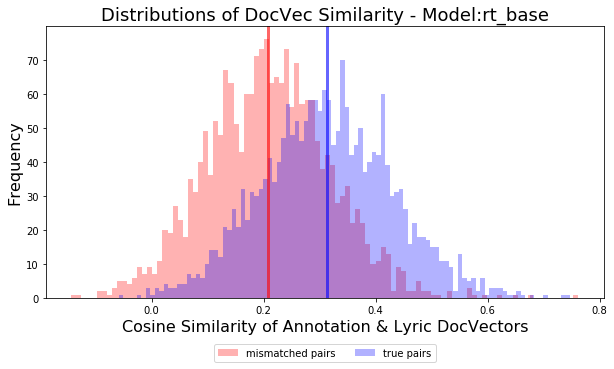

In [10]:
rt_base.plot_sim_distribution(use_train=True, use_cs=True, save_fig=False)

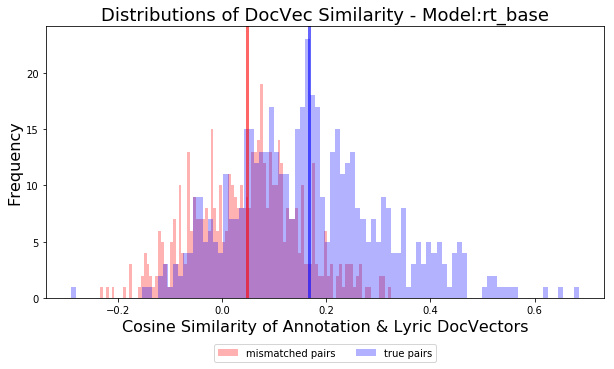

In [11]:
rt_base.plot_sim_distribution(use_train=False, use_cs=True, save_fig=False)

In [13]:
4*3*3*3

108

In [15]:
x = {'a':{'x':2, 'y':3, 'z':1}, 'b':{'x':5, 'y':9, 'z':90}}
pd.DataFrame.from_dict(x, orient='index', columns = ['x', 'y', 'z'])

,x,y,z
a,2,3,1
b,5,9,90
